In [1]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils4t import format_time

results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

idx = pd.IndexSlice
np.random.seed(42)

DATA_STORE = 'data/assets.h5'

D:\99.Dev\Python\pythonProject\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
D:\99.Dev\Python\pythonProject\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

In [3]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']


def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1).astype(int)
    return df


def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df, columns=cols + ['sector'], prefix=cols + [''], prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})


def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [4]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)
X_factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 358914 entries, ('A', Timestamp('2001-01-31 00:00:00')) to ('ZUMZ', Timestamp('2018-02-28 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      358914 non-null  float64
 1   return_2m      358914 non-null  float64
 2   return_3m      358914 non-null  float64
 3   return_6m      358914 non-null  float64
 4   return_9m      358914 non-null  float64
 5   return_12m     358914 non-null  float64
 6   Mkt-RF         358914 non-null  float64
 7   SMB            358914 non-null  float64
 8   HML            358914 non-null  float64
 9   RMW            358914 non-null  float64
 10  CMA            358914 non-null  float64
 11  momentum_2     358914 non-null  float64
 12  momentum_3     358914 non-null  float64
 13  momentum_6     358914 non-null  float64
 14  momentum_9     358914 non-null  float64
 15  momentum_12    358914 non-null  float64
 16  

In [5]:
pd.concat([y.tail(), features.tail()])

0  return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                     
ZUMZ   2017-10-31  1.0        NaN        NaN        NaN        NaN        NaN   
       2017-11-30  0.0        NaN        NaN        NaN        NaN        NaN   
       2017-12-31  0.0        NaN        NaN        NaN        NaN        NaN   
       2018-01-31  0.0        NaN        NaN        NaN        NaN        NaN   
       2018-02-28  1.0        NaN        NaN        NaN        NaN        NaN   
       2017-10-31  NaN  -0.024862   0.190660   0.115956  -0.002805  -0.014066   
       2017-11-30  NaN   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  NaN  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  NaN  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  NaN  -0.050602  -0.027386  -0.033200   0.079484   0.036640   

                   return_12m    Mkt-RF       SMB       HML  ...  month  \
ticker date                                                  ...          
ZUMZ   2017-10-31         NaN       NaN       NaN       NaN  ...    NaN   
       2017-11-30         NaN       NaN       NaN       NaN  ...    NaN   
       2017-12-31         NaN       NaN       NaN       NaN  ...    NaN   
       2018-01-31         NaN       NaN       NaN       NaN  ...    NaN   
       2018-02-28         NaN       NaN       NaN       NaN  ...    NaN   
       2017-10-31   -0.019115  0.118684  0.283629  1.061429  ...   10.0   
       2017-11-30   -0.010687 -0.772268  1.001880  1.353344  ...   11.0   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  ...   12.0   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  ...    1.0   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  ...    2.0   

                   return_1m_t-1  return_1m_t-2  return_1m_t-3  return_1m_t-4  \
ticker date                                                                     
ZUMZ   2017-10-31            NaN            NaN            NaN            NaN   
       2017-11-30            NaN            NaN            NaN            NaN   
       2017-12-31            NaN            NaN            NaN            NaN   
       2018-01-31            NaN            NaN            NaN            NaN   
       2018-02-28            NaN            NaN            NaN            NaN   
       2017-10-31       0.430943      -0.019685       0.028340      -0.133333   
       2017-11-30      -0.024862       0.430943      -0.019685       0.028340   
       2017-12-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-01-31      -0.044725       0.235127      -0.024862       0.430943   
       2018-02-28      -0.003601      -0.044725       0.235127      -0.024862   

                   return_1m_t-5  return_1m_t-6  age  msize  sector  
ticker date                                                          
ZUMZ   2017-10-31            NaN            NaN  NaN    NaN     NaN  
       2017-11-30            NaN            NaN  NaN    NaN     NaN  
       2017-12-31            NaN            NaN  NaN    NaN     NaN  
       2018-01-31            NaN            NaN  NaN    NaN     NaN  
       2018-02-28            NaN            NaN  NaN    NaN     NaN  
       2017-10-31      -0.206128      -0.019126  3.0    2.0     3.0  
       2017-11-30      -0.133333      -0.206128  3.0    2.0     3.0  
       2017-12-31       0.028340      -0.133333  3.0    2.0     3.0  
       2018-01-31      -0.019685       0.028340  3.0    2.0     3.0  
       2018-02-28       0.430943      -0.019685  3.0    2.0     3.0  

[10 rows x 29 columns]

In [22]:
X_factors.tail()

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
ZUMZ   2017-10-31  -0.024862   0.190660   0.115956  -0.002805  -0.014066   
       2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
ZUMZ   2017-10-31   -0.019115  0.118684  0.283629  1.061429  2.597181  ...   
       2017-11-30   -0.010687 -0.772268  1.001880  1.353344  2.953964  ...   
       2017-12-31   -0.003996 -0.772493  1.331478  1.327658  3.467731  ...   
       2018-01-31    0.002864 -0.965140  1.664637  1.528651  3.650790  ...   
       2018-02-28   -0.002905  0.074156  1.167027  1.322157  2.983583  ...   

                   month  return_1m_t-1  return_1m_t-2  return_1m_t-3  \
ticker date                                                             
ZUMZ   2017-10-31     10       0.430943      -0.019685       0.028340   
       2017-11-30     11      -0.024862       0.430943      -0.019685   
       2017-12-31     12       0.235127      -0.024862       0.430943   
       2018-01-31      1      -0.044725       0.235127      -0.024862   
       2018-02-28      2      -0.003601      -0.044725       0.235127   

                   return_1m_t-4  return_1m_t-5  return_1m_t-6  age  msize  \
ticker date                                                                  
ZUMZ   2017-10-31      -0.133333      -0.206128      -0.019126    3      2   
       2017-11-30       0.028340      -0.133333      -0.206128    3      2   
       2017-12-31      -0.019685       0.028340      -0.133333    3      2   
       2018-01-31       0.430943      -0.019685       0.028340    3      2   
       2018-02-28      -0.024862       0.430943      -0.019685    3      2   

                   sector  
ticker date                
ZUMZ   2017-10-31       3  
       2017-11-30       3  
       2017-12-31       3  
       2018-01-31       3  
       2018-02-28       3  

[5 rows x 28 columns]

In [23]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

In [24]:
X_factors_clean.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 327668 entries, ('A', Timestamp('2001-07-31 00:00:00')) to ('ZUMZ', Timestamp('2017-03-31 00:00:00'))
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      327668 non-null  float64
 1   return_2m      327668 non-null  float64
 2   return_3m      327668 non-null  float64
 3   return_6m      327668 non-null  float64
 4   return_9m      327668 non-null  float64
 5   return_12m     327668 non-null  float64
 6   Mkt-RF         327668 non-null  float64
 7   SMB            327668 non-null  float64
 8   HML            327668 non-null  float64
 9   RMW            327668 non-null  float64
 10  CMA            327668 non-null  float64
 11  momentum_2     327668 non-null  float64
 12  momentum_3     327668 non-null  float64
 13  momentum_6     327668 non-null  float64
 14  momentum_9     327668 non-null  float64
 15  momentum_12    327668 non-null  float64
 16  

In [25]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index.get_level_values('date').unique().sort_values(ascending=False)
        [:self.n_splits * self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


cv = OneStepTimeSeriesSplit(n_splits=12, test_period_length=1, shuffle=False)
run_time = {}

In [26]:
metrics = {'balanced_accuracy': 'Accuracy', 'roc_auc': 'AUC', 'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1', 'precision_weighted': 'Precision', 'recall_weighted': 'Recall'}


def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf, X=X, y=y, scoring=list(metrics.keys()), cv=cv,
                            return_train_score=True, n_jobs=n_jobs, verbose=1, fit_params=fit_params)
    duration = time() - start
    return scores, duration


# CV Result Handler Functions
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples([tuple(m.split('_', 1)) for m in scores.keys()],
                                        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data, columns=columns).iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results


def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', y='Value', hue='Dataset', col='Metric', data=df, col_order=m,
                    order=['Train', 'Test'], kind="box", col_wrap=3, sharey=False, height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes,
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round, pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300)

In [27]:
# Baseline Classifier to compare with others
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
algo = 'dummy_clf'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    dummy_cv_result, run_time[algo] = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()
# AUC 0.5 = no meaning as just random results

Dataset,Test,Train
Metric,,
AUC,0.503582,0.500008
Accuracy,0.503582,0.500008
F1,0.516424,0.504660
Log Loss,-17.070718,-17.109954
Precision,0.548116,0.504698
Recall,0.505758,0.504622


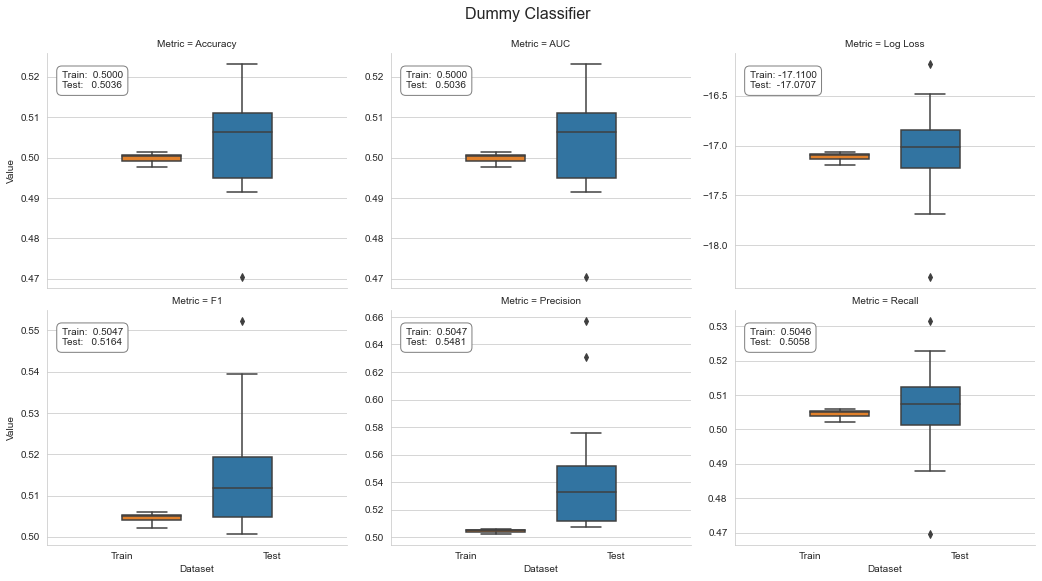

In [28]:
plot_result(dummy_result, model='Dummy Classifier')

In [29]:
# RandomForest
rf_clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                                max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,
                                oob_score=True, n_jobs=-1, random_state=42, verbose=1)

# Cross-validate
algo = 'random_forest'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    rf_cv_result, run_time[algo] = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

In [30]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.529798,1.000000
Accuracy,0.514496,0.999998
F1,0.509672,0.999998
Log Loss,-0.691375,-0.169323
Precision,0.562814,0.999998
Recall,0.543526,0.999998


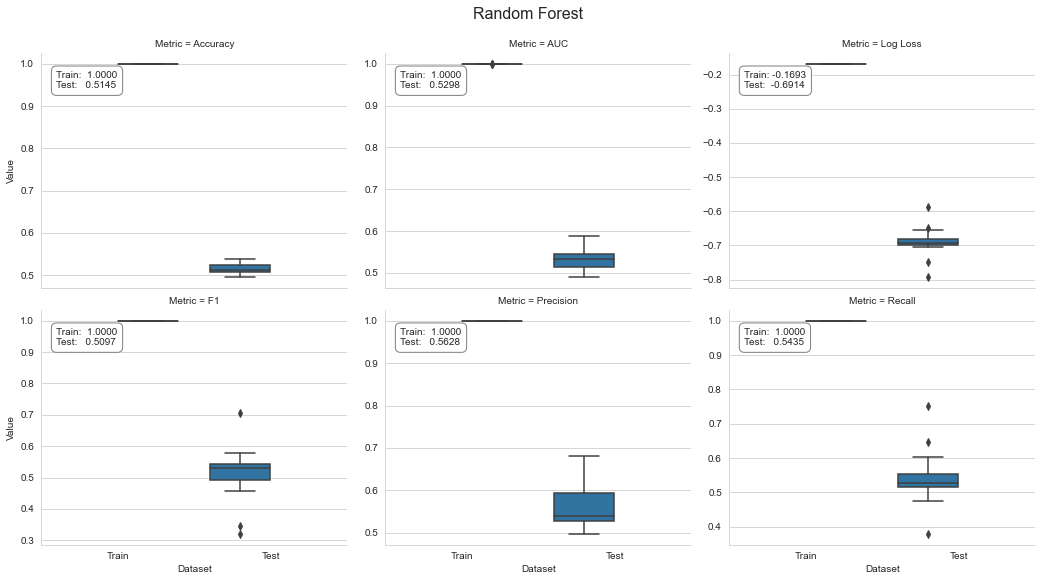

In [31]:
plot_result(rf_result, model='Random Forest')

In [32]:
# scikit-learn: AdaBoost
base_estimator = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1, min_samples_split=2,
                                        min_samples_leaf=20, min_weight_fraction_leaf=0.0, max_features=None,
                                        random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                        class_weight=None)

# algorithm
# SAMME : discrete boosting algorithm
# SAMME.R: default, estimator should support class probability calculation
# Speed: SAMME.R > SAMME :lower test error with fewer boosting iterations
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, learning_rate=1.0,
                             algorithm='SAMME.R', random_state=42)

# Cross-validate
algo = 'adaboost'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    ada_cv_result, run_time[algo] = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

In [33]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.536684,0.608124
Accuracy,0.504776,0.569173
F1,0.461823,0.570940
Log Loss,-0.692848,-0.692697
Precision,0.512652,0.583553
Recall,0.571590,0.588136


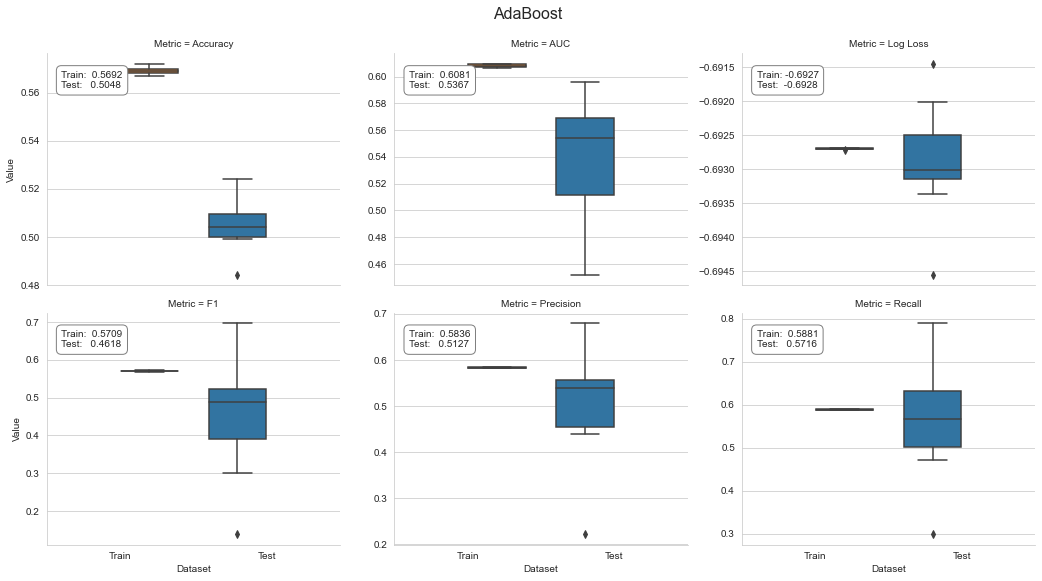

In [34]:
plot_result(ada_result, model='AdaBoost')

In [35]:
# scikit-learn: HistGradientBoostingClassifier(almost default)
gb_clf = HistGradientBoostingClassifier(loss='binary_crossentropy', learning_rate=0.1, max_iter=100,
                                        min_samples_leaf=20, max_depth=None, random_state=None,
                                        max_leaf_nodes=31, warm_start=False,
#                                         early_stopping=True,
#                                         scoring='loss',
#                                         validation_fraction=0.1,
#                                         n_iter_no_change=None,
                                        verbose=0, tol=0.0001)

# Cross-validate
algo = 'sklearn_gbm'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    gb_cv_result, run_time[algo] = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

In [36]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.532428,0.748976
Accuracy,0.506078,0.675291
F1,0.437149,0.681489
Log Loss,-0.700037,-0.595772
Precision,0.565915,0.692624
Recall,0.540851,0.689272


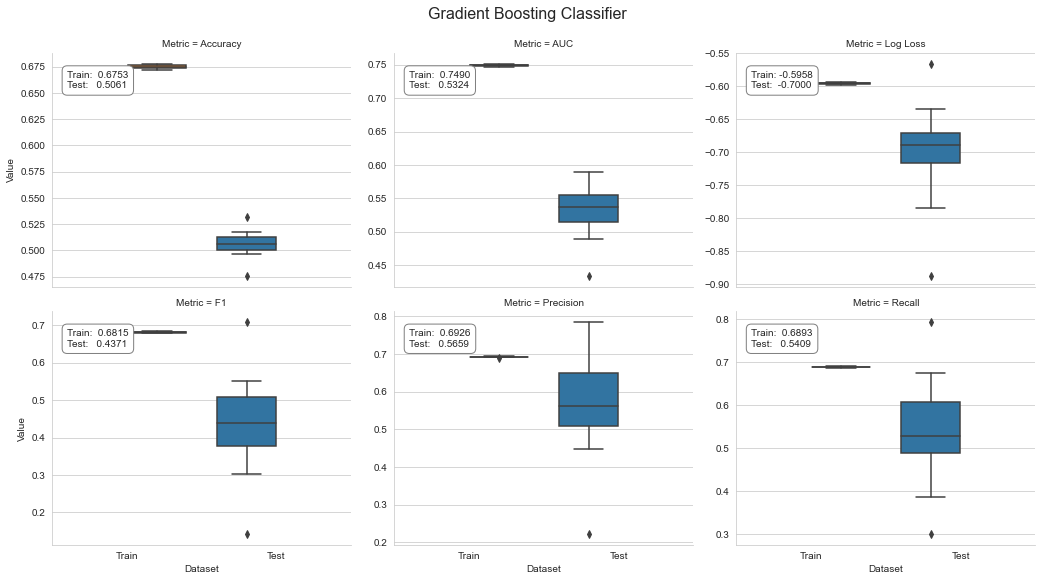

In [37]:
plot_result(gb_result, model='Gradient Boosting Classifier')

In [38]:
# Partial Dependence Plots
X_ = X_factors_clean.drop(['year', 'month'], axis=1)
fname = results_path / f'{algo}_model.joblib'
if not Path(fname).exists():
    gb_clf.fit(y=y_clean, X=X_)
    joblib.dump(gb_clf, fname)
else:
    gb_clf = joblib.load(fname)

# mean accuracy
gb_clf.score(X=X_, y=y_clean)

0.5863740127201924

In [39]:
y_score = gb_clf.predict_proba(X_)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.6117863858551443

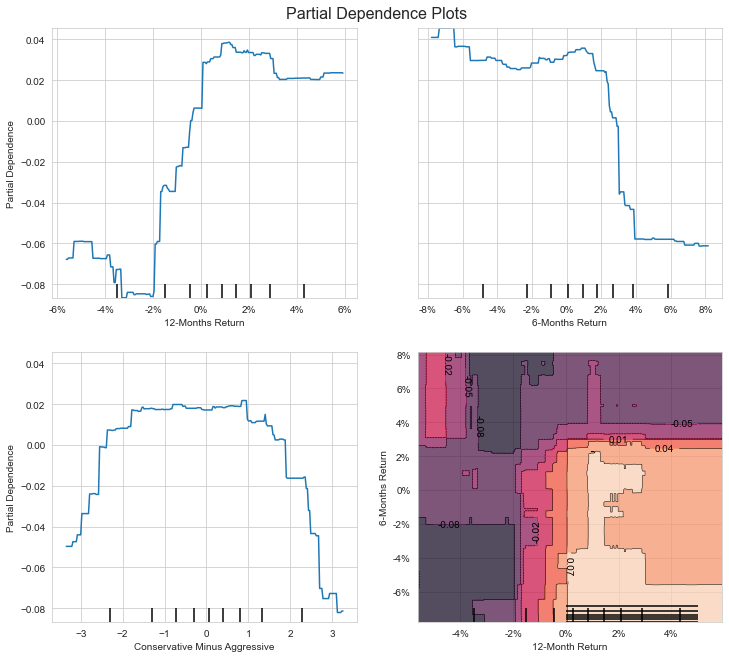

In [40]:
# One-way and two-way partial depende plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

plot_partial_dependence(estimator=gb_clf, X=X_,
                        features=['return_12m', 'return_6m', 'CMA', ('return_12m', 'return_6m')],
                        percentiles=(0.05, 0.95),
                        n_jobs=-1, n_cols=2, response_method='decision_function', grid_resolution=250, ax=axes)

for i, j in product([0, 1], repeat=2):
    if i != 1 or j != 0:
        axes[i][j].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[1][1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axes[0][0].set_ylabel('Partial Dependence')
axes[1][0].set_ylabel('Partial Dependence')
axes[0][0].set_xlabel('12-Months Return')
axes[0][1].set_xlabel('6-Months Return')
axes[1][0].set_xlabel('Conservative Minus Aggressive')

axes[1][1].set_xlabel('12-Month Return')
axes[1][1].set_ylabel('6-Months Return')
fig.suptitle('Partial Dependence Plots', fontsize=16)
fig.subplots_adjust(top=.95)

In [43]:
# Two-way partial dependence as 3D plot
targets = ['return_12m', 'return_6m']
pdp, axes = partial_dependence(estimator=gb_clf, features=targets, X=X_, grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 10))
ax = Axes3D(fig)
surface = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel('12-Month Return')
ax.set_ylabel('6-Month Return')
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# fig.colorbar(surface)
fig.suptitle('Partial Dependence by 6- and 12-month Returns', fontsize=16)

Text(0.5, 0.98, 'Partial Dependence by 6- and 12-month Returns')

<Figure size 1008x720 with 0 Axes>

In [44]:
# XGBoost
xgb_clf = XGBClassifier(max_depth=3,
                        learning_rate=0.1,
                        n_estimators=100,
                        silent=True,  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',  # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,
                        gamma=0,  # Min loss reduction for further splits
                        min_child_weight=1,  # Min sum of sample weight(hessian) needed
                        max_delta_step=0,  # Max delta step for each tree's weight estimation
                        subsample=1,  # Subsample ratio of training samples
                        colsample_bytree=1,  # Subsample ratio of cols for each tree
                        colsample_bylevel=1,  # Subsample ratio of cols for each split
                        reg_alpha=0,  # L1 regularization term on weights
                        reg_lambda=1,  # L2 regularization term on weights
                        scale_pos_weight=1,  # Balancing class weights
                        base_score=0.5,  # Initial prediction score; global bias
                        random_state=42)  # random seed

# Cross-validate
algo = 'xgboost'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

In [45]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.522798,0.685060
Accuracy,0.503764,0.618370
F1,0.396454,0.621572
Log Loss,-0.705026,-0.643714
Precision,0.519174,0.640561
Recall,0.499501,0.637318


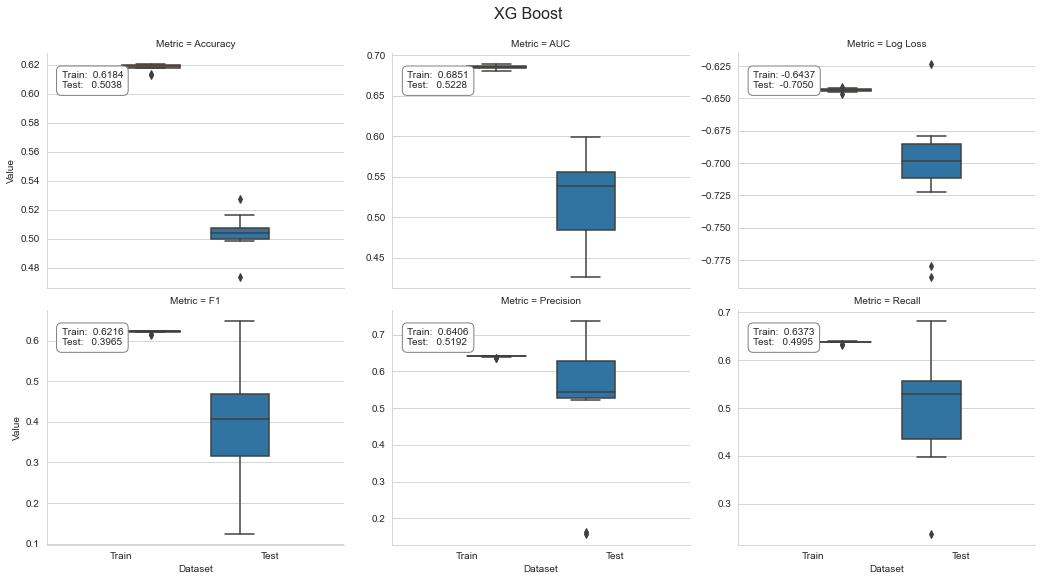

In [46]:
plot_result(xbg_result, model='XG Boost') # , fname=f'figures/{algo}_cv_result')

In [47]:
# Feature Importance
xgb_clf.fit(X=X_dummies, y=y)

[17:31:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:31:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

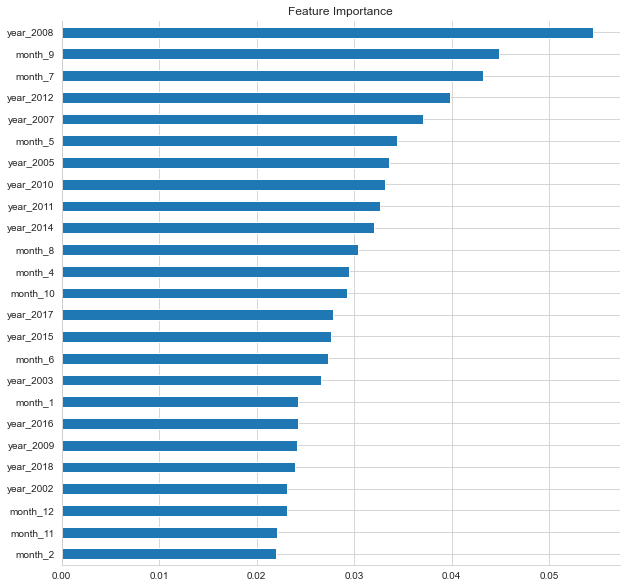

In [48]:
fi = pd.Series(xgb_clf.feature_importances_, index=X_dummies.columns)
fi.nlargest(25).sort_values().plot.barh(figsize=(10, 10), title='Feature Importance')
sns.despine()

In [49]:
# LightGBM
lgb_clf = LGBMClassifier(boosting_type='gbdt',
                         device='gpu',
                         objective='binary',  # learning task
                         metric='auc',
                         num_leaves=31,
                         max_depth=-1,  # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,  # Adaptive lr via callback override in .fit() method
                         n_estimators=100,
                         subsample_for_bin=200000,
                         class_weight=None,  # dict, 'balanced' or None
                         min_split_gain=0.0,  # Minimum loss reduction for further split
                         min_child_weight=0.001,  # Minimum sum of instance weight(hessian)
                         min_child_samples=20,  # Minimum number of data need in a child(leaf)
                         subsample=1.0,  # Subsample ratio of training samples
                         subsample_freq=0,  # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,  # Subsampling ratio of features
                         reg_alpha=0.0,  # L1 regularization term on weights
                         reg_lambda=0.0,  # L2 regularization term on weights
                         random_state=42,  # Random number seed; default: C++ seed
                         n_jobs=-1,
                         silent=False,
                         importance_type='gain',  # default: 'split' or 'gain'
                         )

# Cross-Validate
algo = 'lgb_factors'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result, run_time[algo] = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

In [45]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.525689,0.750019
Accuracy,0.507194,0.676984
F1,0.419113,0.683339
Log Loss,-0.723014,-0.592677
Precision,0.566680,0.691358
Recall,0.494106,0.689661


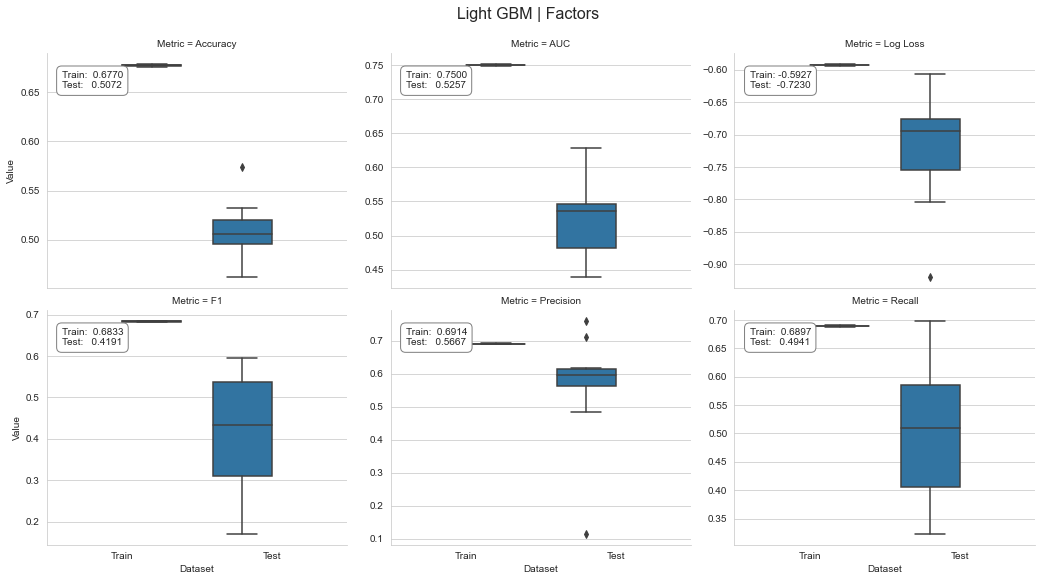

In [66]:
plot_result(lgb_factor_result, model='Light GBM | Factors') # , fname=f'figures/{algo}_cv_result')

In [47]:
# Using dummy variables
algo = 'lgb_dummies'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result, run_time[algo] = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   30.5s remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   32.8s finished


In [48]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.528752,0.743472
Accuracy,0.510860,0.669998
F1,0.424488,0.676076
Log Loss,-0.704981,-0.600770
Precision,0.576025,0.688817
Recall,0.505214,0.684856


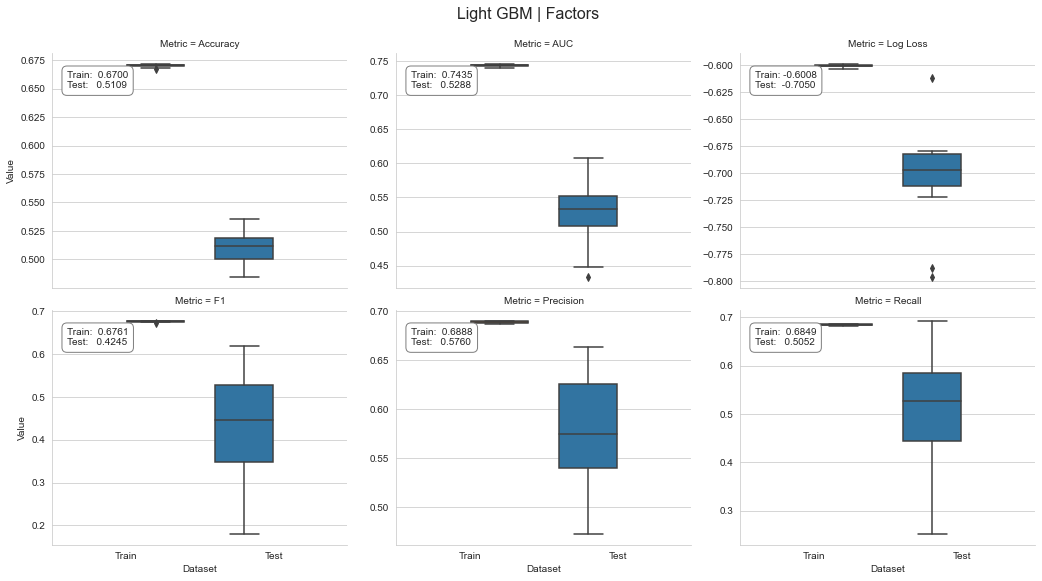

In [67]:
plot_result(lgb_dummy_result, model='Light GBM | Factors') # , fname=f'figures/{algo}_cv_result')

In [50]:
# Catboost

# ver.CPU
cat_clf = CatBoostClassifier()

# Cross-Validate
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

algo = 'catboost'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_cv_result, run_time[algo] = run_cv(cat_clf, X=X_factors, fit_params=fit_params, n_jobs=-1)
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:   48.4s remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.8min finished


In [51]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.521737,0.801126
Accuracy,0.531267,0.719556
F1,0.529803,0.725549
Log Loss,-0.665841,-0.540362
Precision,0.603935,0.728743
Recall,0.616431,0.728398


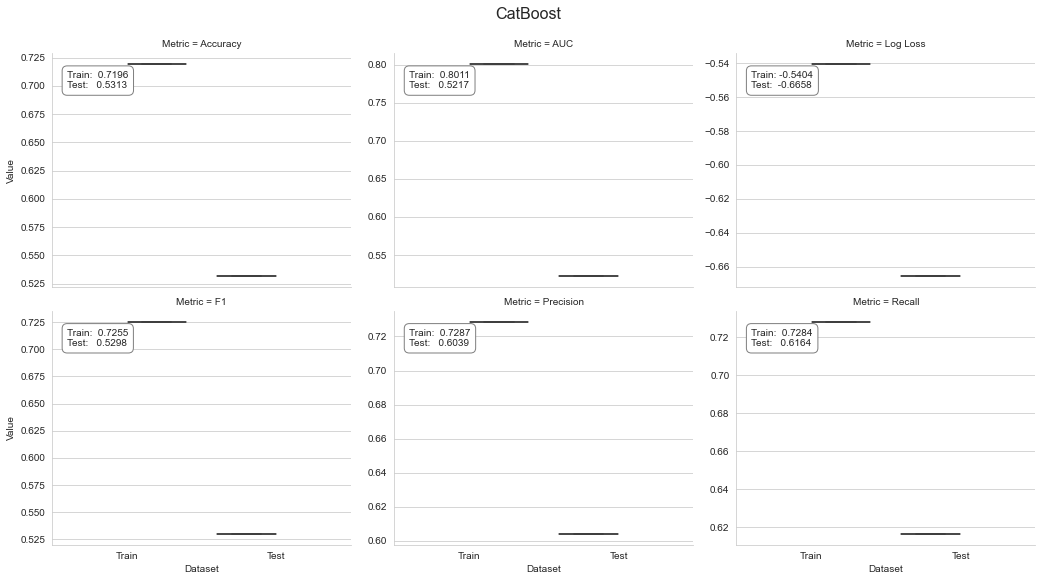

In [68]:
plot_result(cat_result, model='CatBoost') # , fname=f'figures/{algo}_cv_result')

In [53]:
# ver.GPU
cat_clf_gpu = CatBoostClassifier(task_type='GPU')

# Cross-Validate
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

algo = 'catboost_gpu'
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    fit_params = {'cat_features': cat_cols_idx}
    cat_gpu_cv_result, run_time[algo] = run_cv(cat_clf_gpu, y=y, X=X_factors, fit_params=fit_params, n_jobs=1)
    joblib.dump(cat_gpu_cv_result, fname)
else:
    cat_gpu_cv_result = joblib.load(fname)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.024399
0:	learn: 0.6890986	total: 221ms	remaining: 3m 40s
1:	learn: 0.6855579	total: 334ms	remaining: 2m 46s
2:	learn: 0.6818962	total: 381ms	remaining: 2m 6s
3:	learn: 0.6783995	total: 425ms	remaining: 1m 45s
4:	learn: 0.6750776	total: 467ms	remaining: 1m 32s
5:	learn: 0.6721229	total: 507ms	remaining: 1m 24s
6:	learn: 0.6693807	total: 549ms	remaining: 1m 17s
7:	learn: 0.6665249	total: 589ms	remaining: 1m 12s
8:	learn: 0.6639726	total: 628ms	remaining: 1m 9s
9:	learn: 0.6615553	total: 664ms	remaining: 1m 5s
10:	learn: 0.6590158	total: 701ms	remaining: 1m 2s
11:	learn: 0.6566206	total: 738ms	remaining: 1m
12:	learn: 0.6543750	total: 772ms	remaining: 58.6s
13:	learn: 0.6523660	total: 814ms	remaining: 57.4s
14:	learn: 0.6504624	total: 857ms	remaining: 56.3s
15:	learn: 0.6485088	total: 895ms	remaining: 55.1s
16:	learn: 0.6465818	total: 939ms	remaining: 54.3s
17:	learn: 0.6449399	total: 982ms	remaining: 53.6s
18:	learn: 0.6431962	total: 1.02s	remaining: 52.5s
19:	lea

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  9.4min finished


In [54]:
cat_gpu_result = stack_results(cat_gpu_cv_result)
cat_gpu_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.543705,0.770372
Accuracy,0.519040,0.695296
F1,0.483636,0.701373
Log Loss,-0.688470,-0.570048
Precision,0.582591,0.704857
Recall,0.526025,0.704877


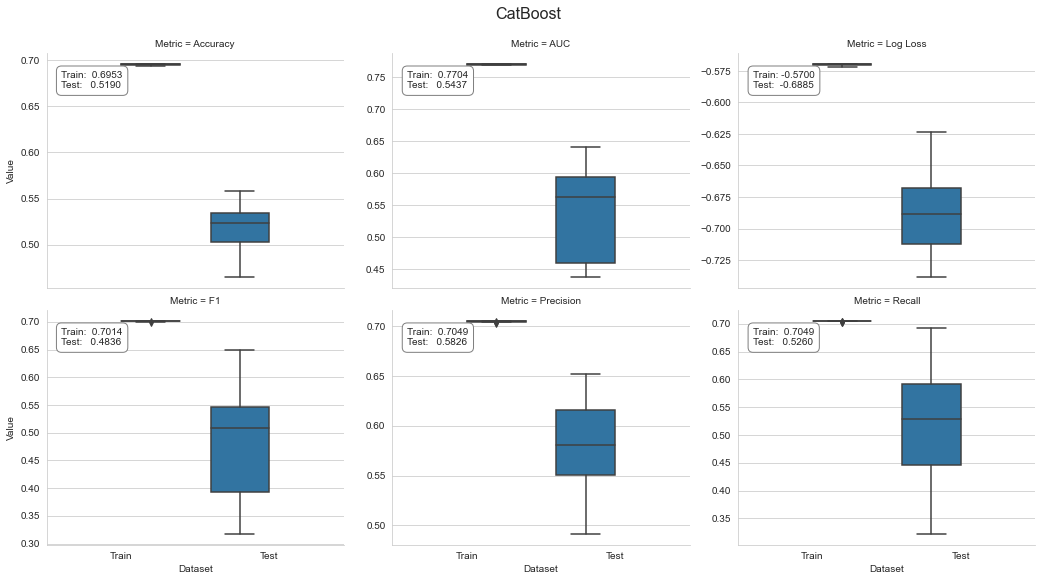

In [69]:
plot_result(cat_gpu_result, model='CatBoost') # , fname=f'figures/{algo}_cv_result')

In [56]:
# Compare Results
results = {'Baseline': dummy_result, 'Random Forest': rf_result, 'AdaBoost': ada_result,
           'Gradient Booster': gb_result, 'XGBoost': xbg_result, 'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result, 'CatBoost': cat_result, 'CatBoost GPU': cat_gpu_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']).Value.mean().unstack()['Test']
                   .to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost GPU,0.543705,0.519040,0.483636,-0.688470,0.582591,0.526025
AdaBoost,0.536684,0.504776,0.461823,-0.692848,0.512652,0.571590
Gradient Booster,0.532428,0.506078,0.437149,-0.700037,0.565915,0.540851
Random Forest,0.529798,0.514496,0.509672,-0.691375,0.562814,0.543526
LightGBM Dummies,0.528752,0.510860,0.424488,-0.704981,0.576025,0.505214
LightGBM Factors,0.525689,0.507194,0.419113,-0.723014,0.566680,0.494106
XGBoost,0.522798,0.503764,0.396454,-0.705026,0.519174,0.499501
CatBoost,0.521737,0.531267,0.529803,-0.665841,0.603935,0.616431
Baseline,0.503582,0.503582,0.516424,-17.070718,0.548116,0.505758


In [57]:
algo_dict = dict(zip(['dummy_clf', 'random_forest', 'adaboost', 'sklearn_gbm',
                      'xgboost', 'lgb_factors', 'lgb_dummies', 'catboost', 'catboost_gpu'],
                     ['Baseline', 'Random Forest', 'AdaBoost', 'Gradient Booster',
                      'XGBoost', 'LightGBM Dummies', 'LightGBM Factors', 'CatBoost', 'CatBoost GPU']))
print(run_time)

{'dummy_clf': 15.393006801605225, 'random_forest': 454.0657002925873, 'adaboost': 431.6467795372009, 'sklearn_gbm': 55.92344689369202, 'xgboost': 283.8238432407379, 'lgb_factors': 48.7797749042511, 'lgb_dummies': 33.13773703575134, 'catboost': 228.10997700691223, 'catboost_gpu': 566.5514104366302}


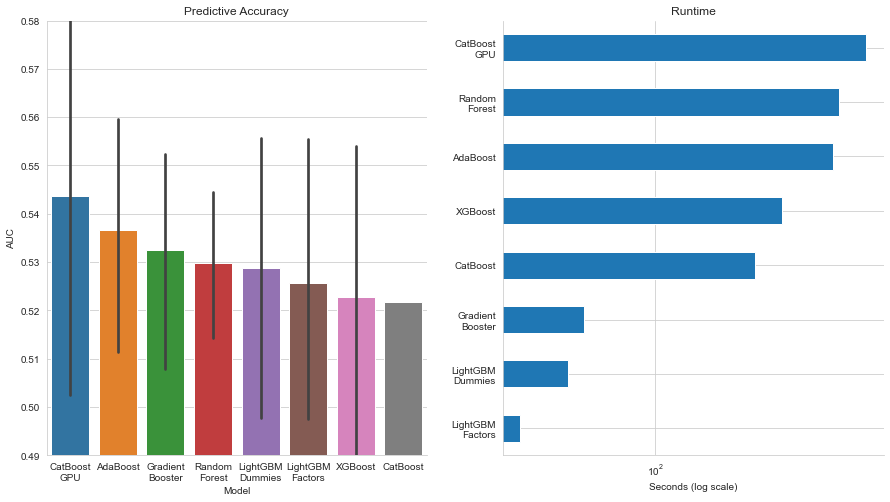

In [70]:
r = pd.Series(run_time).to_frame('t')
r.index = r.index.to_series().map(algo_dict)
r.to_csv(results_path / 'runtime.csv')
# r = pd.read_csv(results_path / 'runtime.csv', index_col=0)
auc = pd.concat([v.loc[(v.Dataset == 'Test') & (v.Metric == 'AUC'), 'Value'].to_frame('AUC').assign(Model=k)
                 for k, v in results.items()])

fig, axes = plt.subplots(figsize=(15, 8), ncols=2)
idx = df.T.drop('Baseline')['AUC'].sort_values(ascending=False).index
sns.barplot(x='Model', y='AUC', data=auc, order=idx, ax=axes[0])
axes[0].set_xticklabels([c.replace(' ', '\n') for c in idx])
axes[0].set_ylim(.49, .58)
axes[0].set_title('Predictive Accuracy')

(r.drop('Baseline').sort_values('t').rename(index=lambda x: x.replace(' ', '\n'))
 .plot.barh(title='Runtime', ax=axes[1], logx=True, legend=False))
axes[1].set_xlabel('Seconds (log scale)')
sns.despine()